# Analysis Notebook
This Jupyter notebook contains important plots present in the paper with relevant descriptions. The first cell contains importing of relevant packages and code, make sure dependencies are fulfilled and compatible. 

The notebook is divided into sections:
- [Initializing](#initializing)
- [Emulator Training and Validation](#emulator-description)
- [Results: Posterior Distribution](#corner-plot)
- [Calculations using Model Parameters](#calculations-using-model-parameters)


In [1]:
from my_plotting import *
from my_functions import *
from joblib import load
sns.set()
sns.set_style('ticks')
plt.rcParams.update({'xtick.labelsize': 14,
                     'ytick.labelsize': 14,
                     'axes.labelsize': 16,
                     'axes.titlesize': 20,
                     'legend.fontsize': 14,
                     'legend.title_fontsize': 14,
                     #'figure.autolayout': True,
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',})
            

## Initializing
Load important files and data:
- pickled emulator, pca, and scaler
- training and validation set
- parameter set
- experimental data in relevant kinematical range
- parameter samples
- posterior samples (or just sample from the complete set)
- model values for posterior samples

In [2]:
# first decide if we are dealing with correlated setup and which model
correlated_ = True
model_ = "mv5" # or "mv5" for the 5 parameter case

In [3]:
correlated_str = "corr" if correlated_ else "uncorr"
param_names = ["$Q_{s,0}^{2}$ [GeV²])",
               "$\gamma$",
               "$e_c$",
               "$C^{2}$",
               "$\sigma_0/2$ [mb]"] if model_ == "mv5" else ["$Q_{s,0}^{2}$ [GeV²]",
               "$e_c$",
               "$C^{2}$",
               "$\sigma_0/2$ [mb]"]
n_params = 5 if model_ == "mv5" else 4
# all files
folder = model_ + '/' + correlated_str
exp_file = "hera_allerrors.csv"
gpe_pkl = folder+"/gpe.pkl"
pca_pkl = folder+"/pca.pkl"
scaler_pkl = folder+"/scaler.pkl"
train_file, theta_file = model_+"/training/train.dat", model_+"/training/theta.dat"
train_file_val, theta_file_val = model_+"/validation/train.dat", model_+"/validation/theta.dat"
theta_post_all_file = folder+"/theta_all.dat"
train_file_post, theta_file_post = folder+"/train.dat", folder+"/theta.dat"
mean_model_file = folder+"/mean.dat"
median_model_file = folder+"/median.dat"
map_model_file = folder+"/map.dat"

In [4]:
# load from files 
# Emulator and emulator predictions
# gpe = load(gpe_pkl, mmap_mode='r') 
# pca = load(pca_pkl)
# scaler = load(scaler_pkl)
# emulators = [gpe, pca, scaler]
# fix error with __randomstate_ctor() takes from 0 to 1 positional arguments but 2 were given
# sklearn version compatibitility does not fix, try overall package compatibility

# emulator training
train, theta = load_training_data(train_file, theta_file)
npc =  6 # dont change
emulators = train_PCA_GPE(train, theta, primary_components = npc, noise_level_bounds_= (1e-10, 1e1), show_var = True)
pred, err = return_predictions(emulators, theta, correlated=correlated_)

# emulator validation
train_val, theta_val = load_training_data(train_file_val, theta_file_val)
pred_val, err_val = return_predictions(emulators, theta_val, correlated=correlated_)

# emulator and bayesian posterior validation
train_post, theta_post = load_training_data(train_file_post, theta_file_post)
pred_post, err_post = return_predictions(emulators, theta_post, correlated=correlated_)

# Posterior samples
theta_post_all = np.vstack(np.loadtxt(theta_post_all_file))

# Experimental dataframe with columns:
exp_df, exp, exp_err, xbj = load_exp(exp_file, correlated = correlated_)

# mean, median and map values
l_bounds = [0.04, 0.9, 0.5, 2.0, 12.0] if model_ == "mv5" else [0.04, 0.5, 2.0, 12.0]
u_bounds = [0.11, 1.1, 60.0, 10.0, 18.0] if model_ == "mv5" else [0.11, 60.0, 10.0, 18.0]
median = np.median(theta_post_all, axis=0).reshape(1,-1)
mean = np.mean(theta_post_all, axis=0).reshape(1,-1)
MAP = minimize(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err, correlated = correlated_), median.reshape(-1)).x
MAP = MAP.reshape(1,-1)
median_model = np.loadtxt(median_model_file)
mean_model = np.loadtxt(mean_model_file)
MAP_model = np.loadtxt(map_model_file)

Explained variance ratio: [9.92128071e-01 6.52022106e-03 1.28679227e-03 6.22060404e-05
 1.84324488e-06 7.84900789e-07]
Sum of explained variance ratio: 0.999999918229108


/home/carlislecasuga/Desktop/BayesianBK_results/my_functions.py:137: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  exp_df['uncor_tot'] = np.sqrt((exp_df['stat'])**2 + (exp_df['uncor'])**2) # total uncorrelated errors
/home/carlislecasuga/Desktop/BayesianBK_results/my_functions.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  exp_df['cor_wo_proc'] = np.sqrt((exp_df['ignore'])**2 - (exp_df['uncor_tot'])**2) # total correlated uncertainties without procedural
/home/carlislecasuga/Desktop/BayesianBK_results/my_functions.py:140:

In [5]:
# set display print options to 3 significant digits
np.set_printoptions(precision=4)
median_84= np.percentile(theta_post_all, 84, axis=0).reshape(1,-1)
median_16= np.percentile(theta_post_all, 16, axis=0).reshape(1,-1)
print("Mean", mean)
print("Median", median)
print("+", median_84 - median)
print("-", median - median_16)
print("MAP", MAP)

Mean [[ 0.0711  1.0108 29.0407  4.8268 13.9714]]
Median [[ 0.0669  1.0085 27.5098  4.7182 13.9652]]
+ [[2.0686e-02 2.0230e-02 2.1652e+01 1.1097e+00 6.5068e-01]]
- [[9.8277e-03 1.4264e-02 1.7467e+01 9.3820e-01 6.5116e-01]]
MAP [[ 0.0765  1.0135 15.6503  4.4674 13.8585]]


## Emulator Description
The training set is generated by sampling the parameter space with a latin hypercube design. The parameter space is defined by the following parameters: $Q_{s0}^2$, $\gamma$, $e_c$, $C^{2}$, $\sigma_0/2$. The final prior bounds used in the study is a result of multiple iterations of the Bayesian sampling and each time making, what was initially, a very generous parameter space even smaller for better emulator predictions. In a latin hypercube, the parameter vectors for the model to be calculated on and the emulator to be trained on are sampled evenly across the space such that there is no redundancy in each individual parameter.

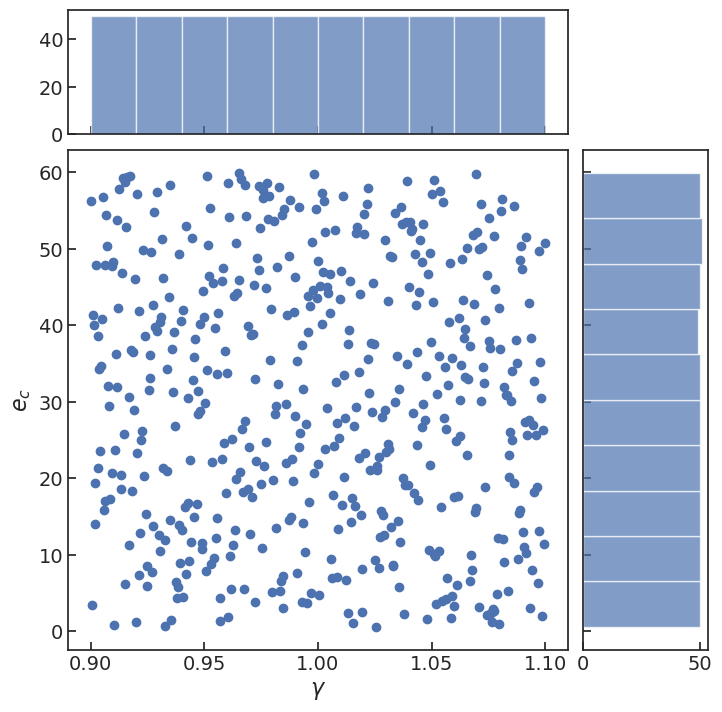

In [6]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
scatter_hist(1, 2, ax, ax_histx, ax_histy, theta, param_names)

### Emulator Validation
The following shows comparison of emulator prediction to HERA data and model calculation to a validation set of 100 parameter vectors to validate the emulator before feeding it into the bayesian sampler.

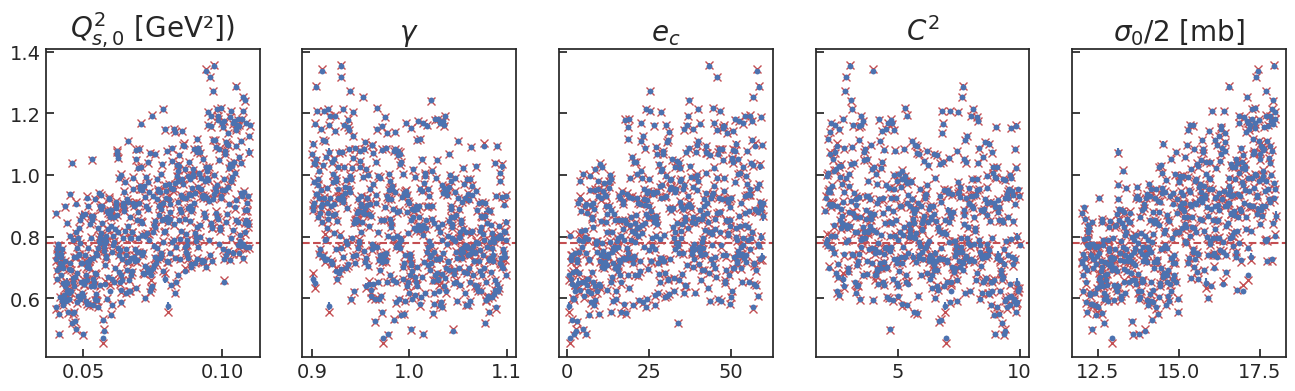

In [7]:
kp = 0
sd_val = np.sqrt(np.diagonal(err_val, axis1 = 1, axis2 = 2)) if correlated_ else err_val
fig, ax = plot_validation_perkp(0, pred_val, sd_val, train_val, exp, n_params, theta_val, param_names)

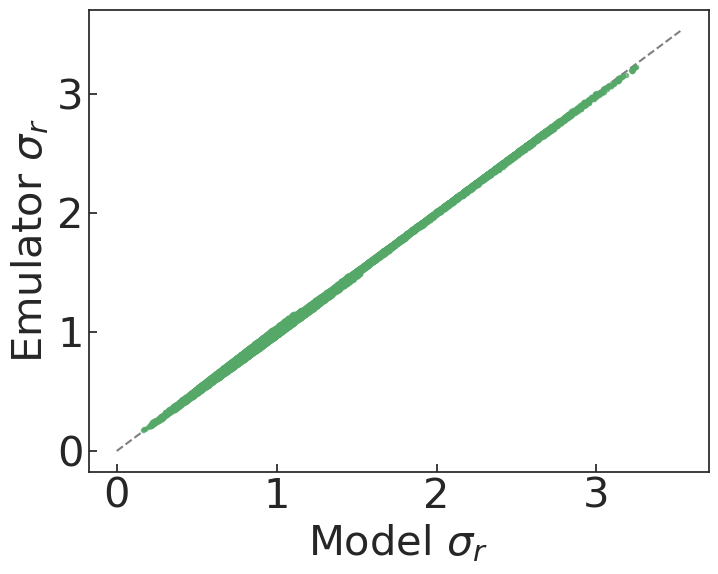

In [8]:
fig, ax = plot_diagonal(pred_val, train_val)
ax.xaxis.get_label().set_fontsize(30)
ax.yaxis.get_label().set_fontsize(30)
ax.tick_params(axis='both', which='major', labelsize=30)
fig.savefig("plots/{}_val_diagonal.pdf".format(model_), bbox_inches='tight')
fig.savefig("plots/{}_val_diagonal.png".format(model_), bbox_inches='tight')

In [9]:
diff = np.array([(pred_val[:,kp] - train_val[:,kp])/train_val[:,kp] for kp in range(403)])
mean_pertheta = np.mean(diff, axis=1)
mean_all = np.mean(mean_pertheta)
print("mean relative error =", mean_all)

mean relative error = 0.00047301411793591153


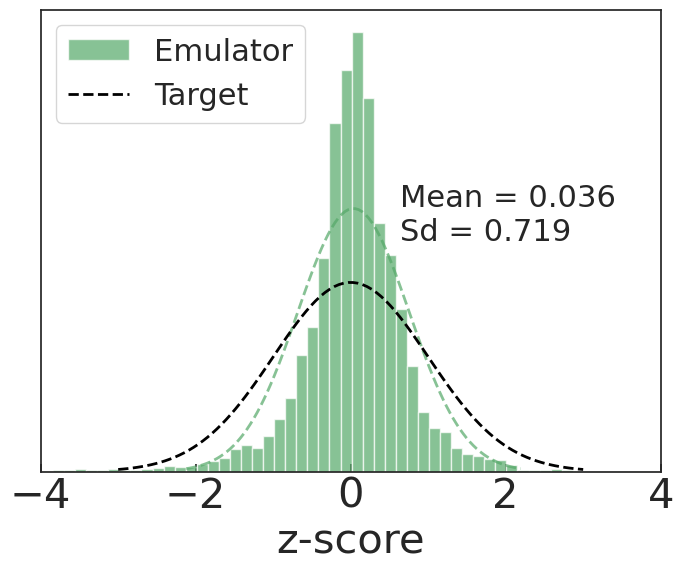

In [10]:
fig, ax = plot_zscore(pred_val, train_val, sd_val, bins_ = 80, text_x = 0.58, text_y = 0.5)
ax.set_yticklabels([])
ax.set_ylabel("")
ax.tick_params(which='major', axis = 'y', size = 0)
ax.set_xlim(-4.0, 4.0)
ax.xaxis.get_label().set_fontsize(30)
ax.tick_params(axis='x', which='major', labelsize=30)
ax.legend(fontsize=22, loc='upper left')
fig.savefig("plots/{}_val_zscore.pdf".format(model_), bbox_inches='tight')

## Corner plot
Running the MCMC results to a posterior distribution describing the areas of high posterior probability. Diagonal plots of the triangle diagram are 1D projections of the posterior distribution for each parameter. The off-diagonal plots are 2D projections of the posterior distribution for each pair of parameters that show the correlation between the pair. The broken lines shows the parameter values at the posterior median, or the 50th percentile. Right after the corner plots, median and MAP values are printed for each parameter.

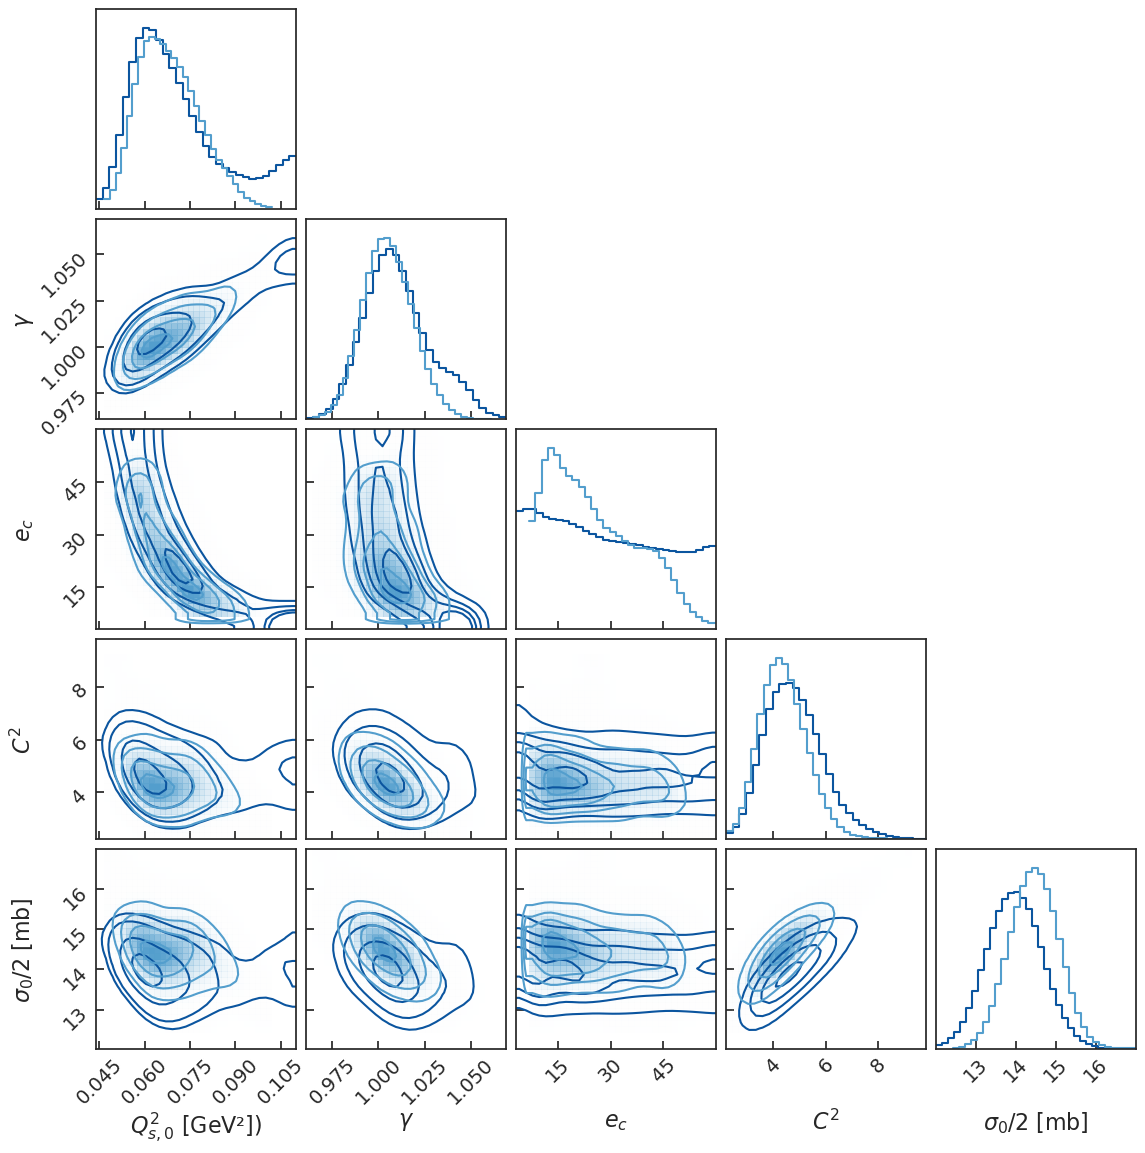

In [11]:
theta_tocompare = np.vstack(np.loadtxt("../BayesianBK/run_corr/mv5/plainLHS/run2_mv5_500d_uncorr_05to60_100w_mapinit_allsamples.txt", unpack = True)).T
fig2, corner = plot_1corner(theta_post_all, param_names, color_= '#0b559f')
plot_corner_tocompare(theta_tocompare, fig2, corner, color_ = '#539ecd')
#fig2.savefig("plots/corr_vs_uncorr_corner.pdf", bbox_inches='tight')'#a6cee3', '#1f78b4'

In [12]:
def plot_corner(mve_samples, mv5_samples, color_mv5 = 'b', color_mve = 'r'):
    hm = [0.06, 18.9, 7.2, 16.36, 1.0]
    param_names = [r"$Q_{s,0}^{2}$ [GeV²]",
               r"$e_c$",
               r"$C^{2}$",
               r"$\sigma_0/2$ [mb]",
               r"$\gamma$",] 
    from scipy.ndimage import gaussian_filter
    fig_kw = {'linewidth': 2.0}
    fig, axes = plt.subplots(5,5, 
                             figsize = (18,18),
                             constrained_layout = False,
                             **fig_kw)
    plt.subplots_adjust(wspace = 0.07, hspace = 0.07)

    for i,j in itertools.product(range(5), range(5)):
        axes[i,j].tick_params(axis='both', 
                              which='major',
                              direction = 'out', 
                              labelsize = 18, 
                              size = 8, 
                              width = 2.5, 
                              pad = 1.0,
                              )
        axes[i,j].spines[['left', 'right', 'top', 'bottom']].set_linewidth(2.0)


    # axes limits
    range0 = [0.045, 0.11]
    range1 = [2.0, 60.0]
    range2 = [2.0, 8.5]
    range3 = [11.8, 16.6]
    range4 = [0.95, 1.08]
    xranges = np.array([range0, range1, range2, range3, range4])
    hist_plot_kwargs= {'linewidth': 2.5, 'drawstyle': 'steps-mid'}
    hist_kwargs = {'density': True,
                   'bins': 30}
    hist2d_kwargs = {"bins" : 30, 
                     "smooth" : 1.7,
                     "plot_datapoints" : False,
                     "plot_density":True,}
    
    for i in range(5):
        axes[i,i].tick_params(which='major', labelrotation=35)
        if i == 4:
            n_mv5, bins_mv5 = np.histogram(mv5_samples[:,i], **hist_kwargs)
            n_mv5 = gaussian_filter(n_mv5, sigma = 1.5)
            x0 = np.array(list(zip(bins_mv5[:-1], bins_mv5[1:]))).flatten()
            y0 = np.array(list(zip(n_mv5, n_mv5))).flatten()
            axes[i,i].plot(x0, y0, color = color_mv5, **hist_plot_kwargs)
            
            axes[i,i].set_xlim(xranges[i])
            axes[i,i].set_ylim([0.0,None])
            axes[i,i].axvline(1.0, color = color_mve, linestyle = '-', linewidth = 3.0)

        else:
            n_mv5, bins_mv5 = np.histogram(mv5_samples[:,i], **hist_kwargs)
            n_mv5 = gaussian_filter(n_mv5, sigma = 1.5)
            x0 = np.array(list(zip(bins_mv5[:-1], bins_mv5[1:]))).flatten()
            y0 = np.array(list(zip(n_mv5, n_mv5))).flatten()
            axes[i,i].plot(x0, y0, color = color_mv5, **hist_plot_kwargs)
            
            n_mve, bins_mve = np.histogram(mve_samples[:,i],**hist_kwargs)
            n_mve = gaussian_filter(n_mve, sigma = 1.5)
            x02 = np.array(list(zip(bins_mve[:-1], bins_mve[1:]))).flatten()
            y02 = np.array(list(zip(n_mve, n_mve))).flatten()
            axes[i,i].plot(x02, y02, color = color_mve, **hist_plot_kwargs)
            axes[i,i].set_xlim(xranges[i])
            axes[i,i].set_ylim([0.0 , None])

        for j in range(i):
            corner.hist2d(mve_samples[:,i], mve_samples[:,j], ax = axes[j,i], color = color_mve, **hist2d_kwargs, contour_kwargs = {'linewidths':2.0})
            axes[j,i].set_xlim(xranges[i])
            axes[j,i].set_ylim(xranges[j])
            axes[j,i].tick_params(which='major', labelrotation=35)
            corner.hist2d(mv5_samples[:,j], mv5_samples[:,i], ax = axes[i,j], color = color_mv5, **hist2d_kwargs, contour_kwargs = {'linewidths':2.0})
            axes[i,j].set_xlim(xranges[j])
            axes[i,j].set_ylim(xranges[i])
            axes[i,j].tick_params(which='major', labelrotation=35)
        
    for i in range(5):
        axes[i,i].axvline(hm[i], color = 'g', linestyle = ':', linewidth = 3.0)    
    
    for i in range(1,3):
        for j in range(5):
            axes[j,i].set_yticklabels([])
            axes[j,i].tick_params(which='major', axis = 'y', size = 0)

    axes[4,3].set_yticklabels([])
    axes[4,3].tick_params(which='major', axis = 'y', size = 0)
    axes[4,4].set_yticklabels([])
    axes[4,4].tick_params(which='major', axis = 'y', size = 0)
    axes[0,0].set_yticklabels([])
    axes[0,0].tick_params(which='major', axis = 'y', size = 0)

    for i in range(1,5):
        axes[i,0].set_ylabel(param_names[i], fontsize = 24) #if ((i != 0) & (i != 4)) else axes[i,0].set_ylabel(param_names[i], fontsize = 24, labelpad = 10)
        axes[i-1,3].set_ylabel(param_names[i-1], fontsize = 24) #if i != 1 else axes[i-1,3].set_ylabel(param_names[i-1], fontsize = 24, labelpad = 10)

        #axes[i-1,3].set_yticklabels([])
        axes[i-1,3].yaxis.set_label_position("right")
        axes[i-1,3].yaxis.tick_right()
        #axes[0,3].set_ylabel(param_names[0])
        #axes[0,3].yaxis.set_label_position("right")
        fig.delaxes(axes[i-1,4])
    
    # manually removing and arranging tick positions and axis labels
    for i in range(5):
        axes[4,i].set_xlabel(param_names[i], fontsize = 24) #if ((i != 0) & (i != 4)) else axes[4,i].set_xlabel(param_names[i], fontsize = 24, labelpad = 10)
        axes[0,i].set_xlabel(param_names[i], fontsize = 24) #if ((i != 0) & (i != 4)) else axes[0,i].set_xlabel(param_names[i], fontsize = 24, labelpad = 10)
        axes[0,i].xaxis.set_label_position("top")
        axes[0,i].xaxis.tick_top()
        for j in range(1,4):
            axes[j,i].set_xticklabels([])
            axes[j,i].tick_params(which='major', axis = 'x', size = 0)
    
    axes[3,3].set_ylabel("")
    axes[3,3].set_yticklabels([])
    axes[3,3].tick_params(which='major', axis = 'y', size = 0)
    fig.align_labels()
    return fig, axes


/home/carlislecasuga/miniconda3/envs/myenv/lib/python3.10/site-packages/corner/core.py:915: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  return ax.set_xlim(new_xlim)


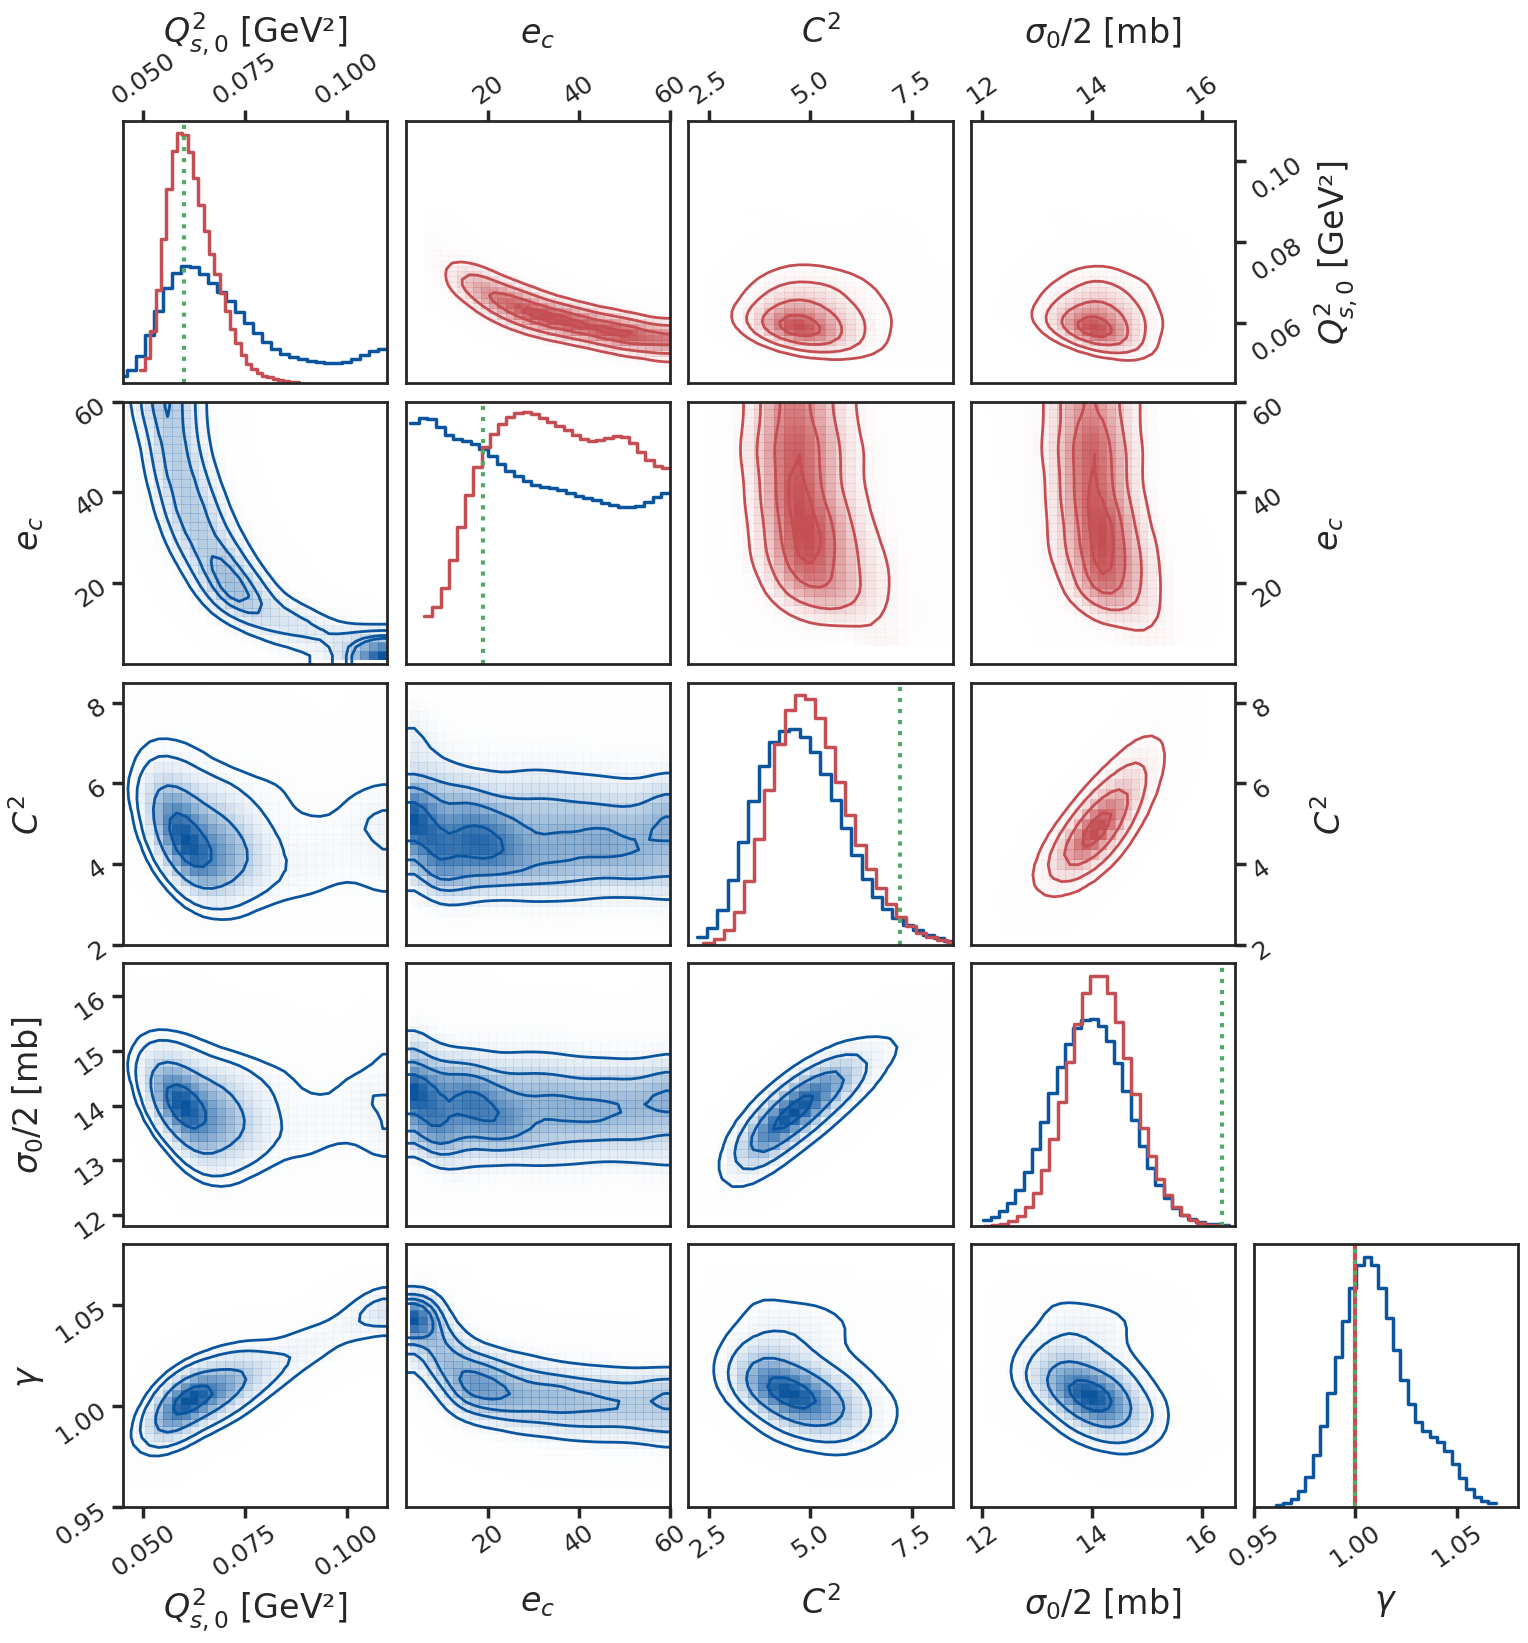

In [13]:
posterior_samples_mve= np.vstack(np.loadtxt("../BayesianBK/run_corr/mve/plainLHS/run2_mve_500d_{}_05to60_100w_mapinit_allsamples.txt".format(correlated_str), unpack=True)).T
posterior_samples_mv5 = theta_post_all
posterior_samples_mv5 = np.insert(posterior_samples_mv5, 5, posterior_samples_mv5[:, 1], axis = 1)
posterior_samples_mv5 = np.delete(posterior_samples_mv5, 1, axis = 1)
posterior_samples_mve_gamma = 1.0*np.ones(len(posterior_samples_mve))
posterior_samples_mve = np.insert(posterior_samples_mve, 4, posterior_samples_mve_gamma, axis = 1)
posterior_samples_mve[0:200, 4] = 1.0
fig_corner, axes = plot_corner(posterior_samples_mve, posterior_samples_mv5, color_mve = 'r', color_mv5='#0b559f')
#fig_corner.savefig("plots/{}_corner_clean.pdf".format(correlated_str), bbox_inches='tight')

### Posterior Validation
Next we visualize different results from sampling from the posterior and then comparing to HERA data the model calculation at the MAP/ Median values.

In [14]:
median_emulator, median_emulator_err = return_predictions(emulators, median, correlated=correlated_)
MAP_emulator, MAP_emulator_err = return_predictions(emulators, MAP, correlated=correlated_)

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': '5-parameter fit'}, xlabel='$x_{bj}$', ylabel='$\\sigma_r$ (mb)'>)

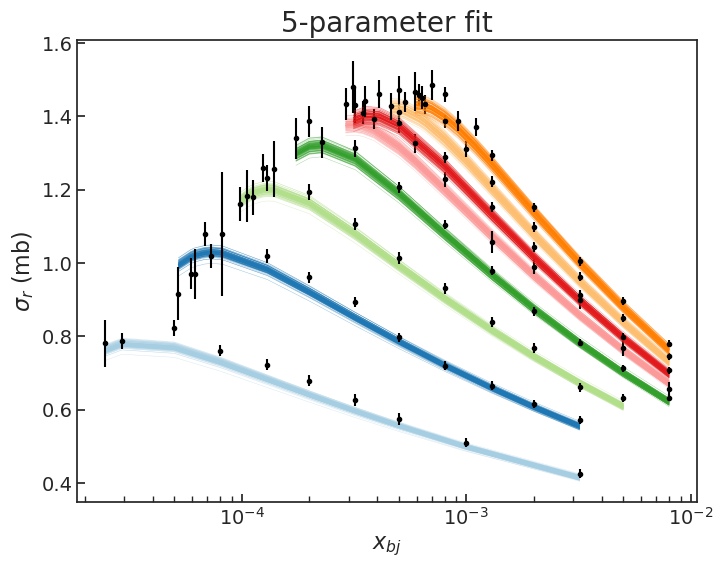

In [15]:
plot_model_vs_exp([2., 4.5, 8.5, 15.0, 22.0,  27.,  35.,  45.], 318.0, train_post, exp_df, exp_err, title_ = "{}-parameter fit".format(n_params), correlated = correlated_)
# other Q2 values 8.5, 15.0, 22.0,  27.,  35.,  45.

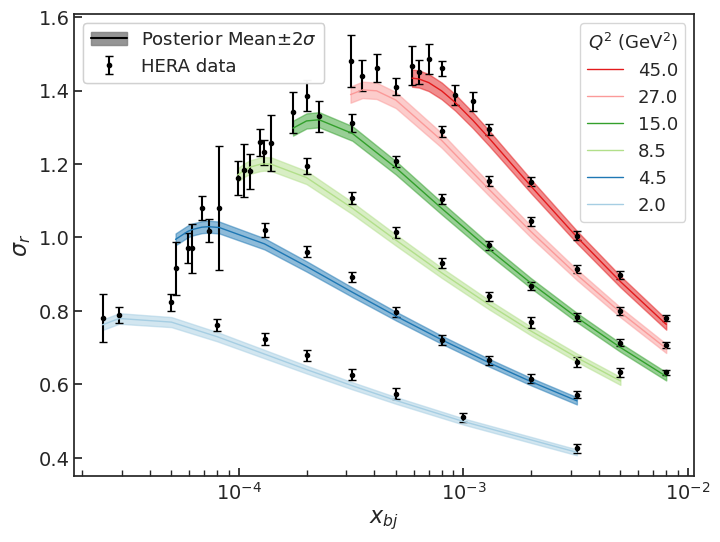

In [17]:
sqrt_s = 318.0
fig, ax = plot_posterior_mean_and_ub([2., 4.5, 8.5, 15.0, 27., 45.], sqrt_s, train_post, exp_df, exp_err, title_ = "", correlated = correlated_)
fig.savefig("plots/{}_{}_{}_posterior_mean_and_ub.pdf".format(model_, correlated_str, sqrt_s), bbox_inches='tight')

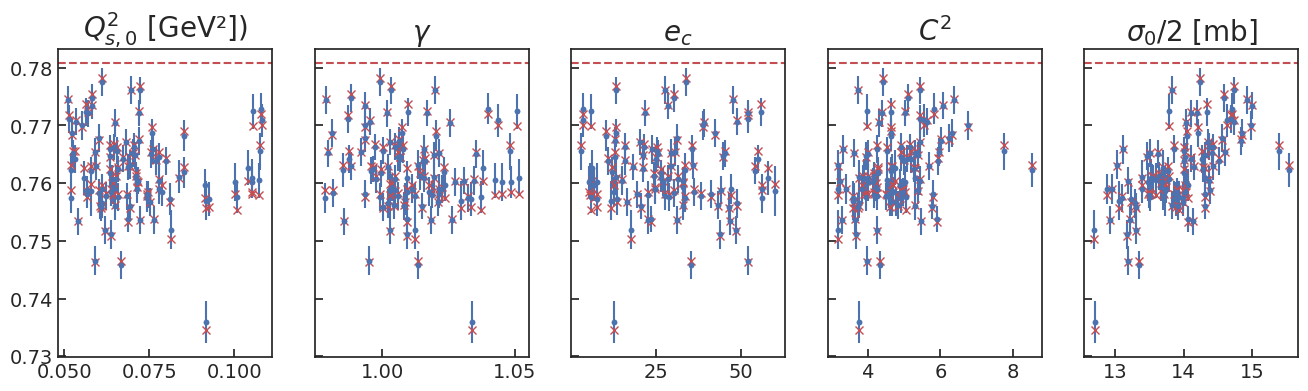

In [17]:
sd_post = np.sqrt(np.diagonal(err_post, axis1 = 1, axis2 = 2)) if correlated_ else err_post
fig, ax = plot_validation_perkp(0, pred_post, sd_post, train_post, exp, n_params, theta_post, param_names)

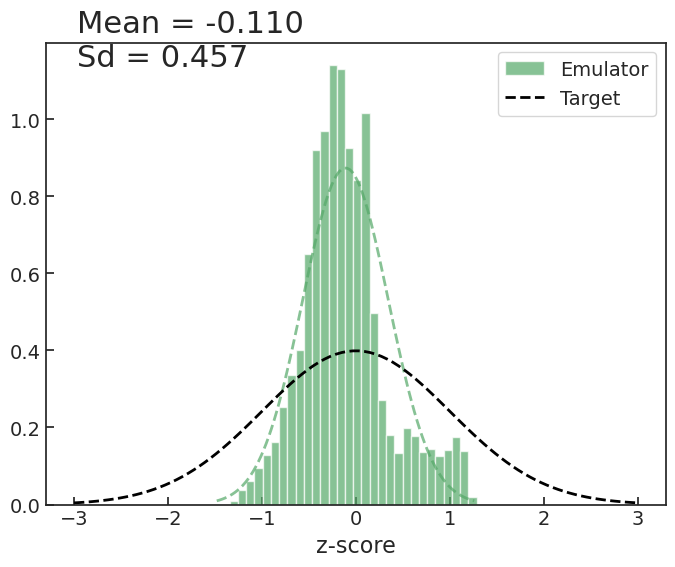

In [18]:
fig, ax = plot_zscore(pred_post, train_post, sd_post)

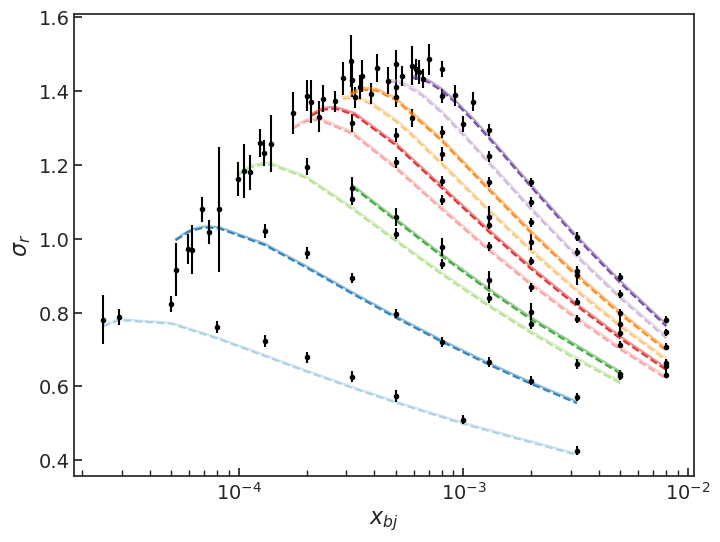

In [19]:
plot_exp_vs_map_vs_median([2., 4.5, 8.5, 10., 15., 18.,  22.,  27.,  35.,  45.], 318.0, MAP_model.reshape(1,403), exp_df, exp_err, median_model.reshape(1,403), correlated = correlated_)

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='Model $\\sigma_r$', ylabel='Emulator $\\sigma_r$'>)

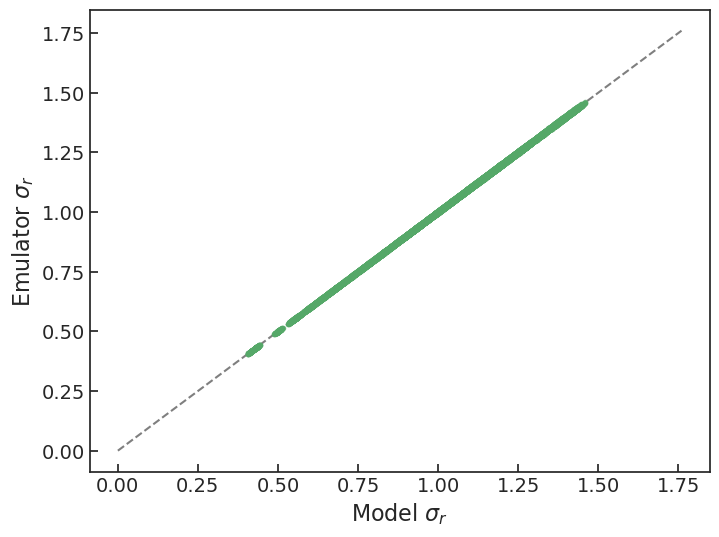

In [20]:
plot_diagonal(pred_post, train_post)

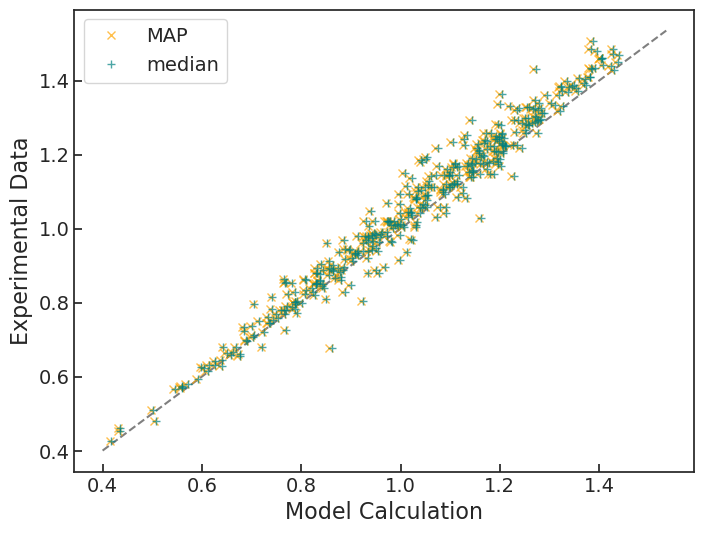

In [21]:
fig3, ax3 = plot_diagonal_1(MAP_model.reshape(403), exp, color_ = 'orange',label_ = "MAP")
ax3.plot(median_model.reshape(403), exp, '+', color = 'teal', alpha = 0.7, label  = "median" )
ax3.legend()
#fig3.savefig("plots/{}_{}_{}_diagonal.pdf".format(model_, correlated_str, 'mapnmedian'), bbox_inches='tight')

In [22]:
print('MAP chi2', my_chi2(exp, MAP_model.reshape(403), np.sqrt(exp_err.diagonal()) if correlated_ else exp_err))
print('median chi2', my_chi2(exp, median_model.reshape(403), np.sqrt(exp_err.diagonal()) if correlated_ else exp_err))
print('mean chi2', my_chi2(exp, mean_model.reshape(403), np.sqrt(exp_err.diagonal()) if correlated_ else exp_err))

MAP chi2 2.064386885311884
median chi2 1.6268861691272398
mean chi2 1.9383205984197989


1.6268861691272396

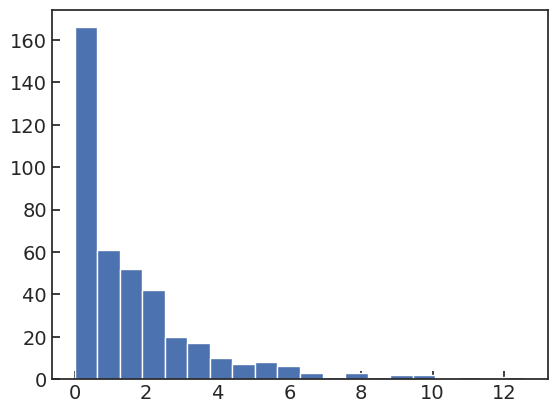

In [23]:
err2 = exp_err.diagonal()
chi2 = ((exp - median_model.reshape(403))**2)/err2
plt.hist(chi2.flatten(), bins = 20)
chi2.mean()

In [24]:
# chi2 for 100 posterior samples
err2 = exp_err.diagonal()
median_over_100 = np.median(train_post, axis = 0)
chi2 = np.sum(((exp - median_over_100)**2)/err2)/403
print(chi2)

2.0774425382269563


## Calculations using Model Parameters
For the following predictions, we take 1000 samples from the posterior distribution and statistically rigorously calculate the median and standard deviation by calculating the quantity for 1000 of the samples and take the mean and sd for each x-value.

In [25]:
n = 1000
inds = np.random.randint(len(theta_post_all), size = n)
theta_post_1000 = np.array([theta_post_all[i] for i in inds])
# unravel the parameter vectors
e_cs = theta_post_1000[:, 2] if model_ == "mv5" else theta_post_1000[:, 1]
Qs02s = theta_post_1000[:, 0]
sigma02s = theta_post_1000[:, -1]
gammas = theta_post_1000[:, 1] if model_ == "mv5" else np.ones(n)

### Initial Dipole Amplitude Shape

In the following cells, we show the initial and evolved dipole amplitude that is constrained by the Bayesian analysis. The initial dipole amplitude is of the form:

$$ N(\mathbf{x}_{ij}, x=x_0) = 1-\exp \left[  - \frac{\left(\mathbf{x}_{ij}^2Q_{s,0}^2\right)^\gamma}{4} \right.
            \times \left. \ln \left( \frac{1}{|\mathbf{x}_{ij}| \Lambda_\text{QCD}}
             +  e_c\cdot  e   \right)   \right]. $$

We can see clearly here the model parameters that express the dipole amplitude. This is input to the BK evolution equation to evolve the dipole amplitude to higher energie and smaller $x$. The running strong coupling in the transverse plane is also input and is given by:

$$ \alpha_s(\mathbf{r}^2) = \frac{12\pi}{33-2n_f \ln\left( \frac{4C^2}{\mathbf{r}^2 \Lambda_{\mathrm{QCD}}^2} \right)}. $$

In [26]:
model_to_comp = "mv5" if model_ == "mve" else "mve"
paramsamples_tocomp = np.vstack(np.loadtxt("../BayesianBK/run_corr/{0}/plainLHS/run2_{0}_500d_{1}_05to60_100w_mapinit_allsamples.txt".format(model_to_comp, correlated_str), unpack=True)).T
theta_tocomp_1000 = np.array([paramsamples_tocomp[i] for i in inds])
e_cs_comp = theta_tocomp_1000[:, 2] if model_to_comp == "mv5" else theta_tocomp_1000[:, 1]
Qs02s_comp = theta_tocomp_1000[:, 0]
sigma02s_comp = theta_tocomp_1000[:, -1]
gammas_comp = theta_tocomp_1000[:, 1] if model_to_comp == "mv5" else np.ones(n)

In [27]:
rs = np.logspace(-2,1,50)
iBK = get_iBK_upsd_downsd(Qs02s, gammas, e_cs, rs)
iBK_usd = iBK[0]+ 2*iBK[1]
iBK_dsd = iBK[0]- 2*iBK[2]

iBK_comp = get_iBK_upsd_downsd(Qs02s_comp, gammas_comp, e_cs_comp, rs)
iBK_comp_usd = iBK_comp[0]+ 2*iBK_comp[1]
iBK_comp_dsd = iBK_comp[0]- 2*iBK_comp[2]

# plot evolved bk now
where_bk_mve = "../BayesianBK/run_corr/run2/mve/corr/bks"
eBK_mve = get_eBK_upsd_downsd(where_bk_mve, rs)
eBK_mve_usd = eBK_mve[0]+ 2*eBK_mve[1]
eBK_mve_dsd = eBK_mve[0]- 2*eBK_mve[2]

where_bk_mv5 = "../BayesianBK/run_corr/run2/mv5/corr/bks"
eBK_mv5 = get_eBK_upsd_downsd(where_bk_mv5, rs)
eBK_mv5_usd = eBK_mv5[0]+ 2*eBK_mv5[1]
eBK_mv5_dsd = eBK_mv5[0]- 2*eBK_mv5[2]

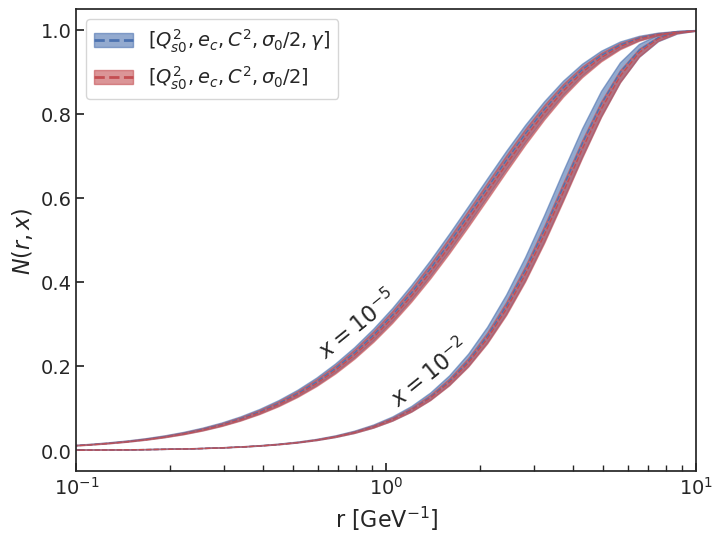

In [49]:
# plot initial bk
fig, ax = plot_pred_mve_vs_mv5(iBK_comp, iBK, rs, r"$N(r,x)$", "r [GeV$^{-1}$]", legend_loc = "upper left", linewidth_=1.0)

ax.plot(rs, eBK_mv5[0], '--', color = "b", linewidth = 1.0)
ax.fill_between(rs, eBK_mv5_usd, eBK_mv5_dsd, color = "b", alpha = 0.6)
ax.plot(rs, eBK_mve[0], '--', color = "r", linewidth = 1.0)
ax.fill_between(rs, eBK_mve_usd, eBK_mve_dsd, color = "r", alpha = 0.6)
ax.set_xscale("log")
ax.set_xlim(.1, 10)
ax.text(0.38, 0.25, r'$x_{} = 10^{-5}$', transform=ax.transAxes, rotation = 39, fontsize = 16)
ax.text(0.5, 0.14, r'$x = 10^{-2}$', transform=ax.transAxes, rotation = 39, fontsize = 16)
fig.savefig("plots/{}_iebk.pdf".format(correlated_str), bbox_inches='tight')

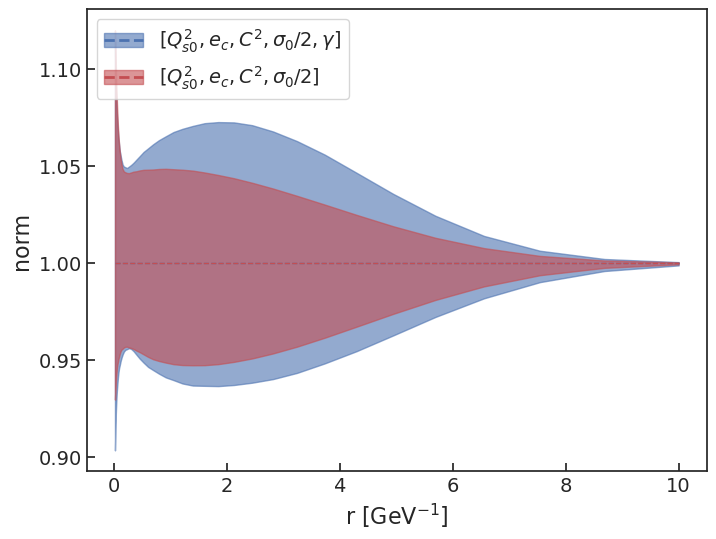

In [35]:
# normalize to 1
iBK_norm = iBK/iBK[0]
iBK_norm_usd = iBK_usd/iBK[0]
iBK_norm_dsd = iBK_dsd/iBK[0]

iBK_comp_norm = iBK_comp/iBK_comp[0]
iBK_comp_norm_usd = iBK_comp_usd/iBK_comp[0]
iBK_comp_norm_dsd = iBK_comp_dsd/iBK_comp[0]

#evolved bk normalize to 1
eBK_mve_norm = eBK_mve/eBK_mve[0]
eBK_mve_norm_usd = eBK_mve_usd/eBK_mve[0]
eBK_mve_norm_dsd = eBK_mve_dsd/eBK_mve[0]

eBK_mv5_norm = eBK_mv5/eBK_mv5[0]
eBK_mv5_norm_usd = eBK_mv5_usd/eBK_mv5[0]
eBK_mv5_norm_dsd = eBK_mv5_dsd/eBK_mv5[0]

# then plot
fig, ax = plot_pred_mve_vs_mv5(iBK_comp_norm, iBK_norm, rs, 'norm', "r [GeV$^{-1}$]", legend_loc = "upper left", linewidth_=1.0)

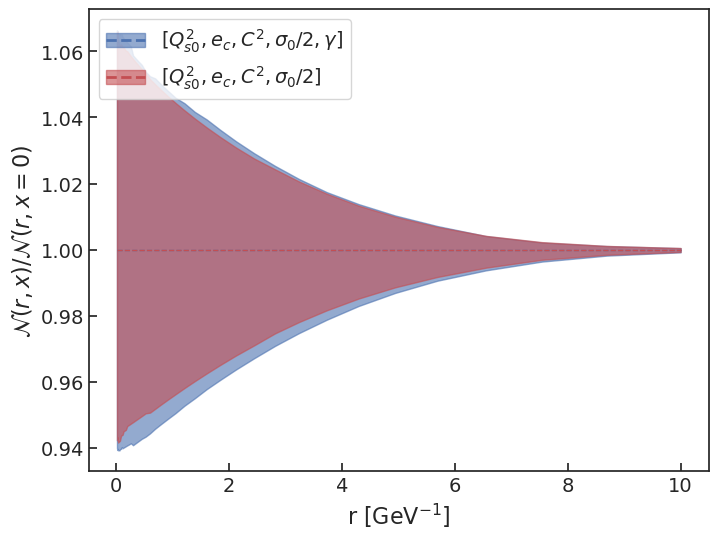

In [34]:
fig, ax = plot_pred_mve_vs_mv5(eBK_mve_norm, eBK_mv5_norm, rs, r"$\mathcal{N}(r,x)/\mathcal{N}(r,x=0)$", "r [GeV$^{-1}$]", legend_loc = "upper left", linewidth_=1.0)

### 2DFT Dipole Amplitude

Given the optimal parameter vector distribution, we can optimize the initial condition for the BK equation where the agreement with HERA is max. Using these "initial conditions", we can provide CGC LO prediction for observables describing pp and pA collisions at the LHC (and in the future, EIC) like particle production. One example is the 2D fourier transform of the dipole proton amplitude which can be directly calculated from the initial condition $N(r)$:


$$ \tilde{S}(k_{T}) = \int d²r e^{ik \cdot r} [1 - N(r)] = 2 \pi \int dr r J_0(k*r) (1 - N(r))$$

In [29]:
k = np.logspace(-1,1,50)
sp = get_2DFT_upsd_downsd(Qs02s, gammas, e_cs, k)
sp_usd = sp[0]+ 2*sp[1]
sp_dsd = sp[0]- 2*sp[2]

sp_comp = get_2DFT_upsd_downsd(Qs02s_comp, gammas_comp, e_cs_comp, k)
sp_comp_usd = sp_comp[0]+ 2*sp_comp[1]
sp_comp_dsd = sp_comp[0]- 2*sp_comp[2]

In [43]:
k_ex = [20]
sp_ex = get_2DFT_upsd_downsd(Qs02s_comp, gammas_comp, e_cs_comp, k_ex)
print(sp_ex[0], sp_ex[1], sp_ex[2])

[9.2045e-08] [4.4335e-08] [1.398e-08]


In [47]:
print('upper sd ratio: ', sp_ex[1]/sp_ex[0])
print('lower sd ratio: ', sp_ex[2]/sp_ex[0])

upper sd ratio:  [0.4817]
lower sd ratio:  [0.1519]


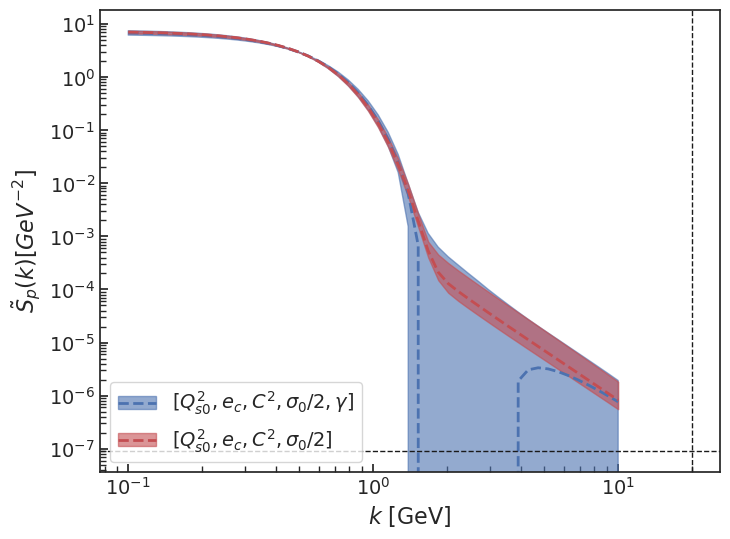

In [46]:
fig, ax = plot_pred_mve_vs_mv5(sp_comp, sp, k, r'$\tilde{S}_{p}(k) [GeV^{-2}]$', "$k$ [GeV]", legend_loc = "lower left", xlogscale= True, ylogscale = True)
ax.axhline(sp_ex[0], color = 'k', linestyle = '--', linewidth = 1.0)
ax.axvline(k_ex[0], color = 'k', linestyle = '--', linewidth = 1.0)
#fig.savefig("plots/{}_sp.pdf".format(correlated_str), bbox_inches='tight')

(-2.0, 4.0)

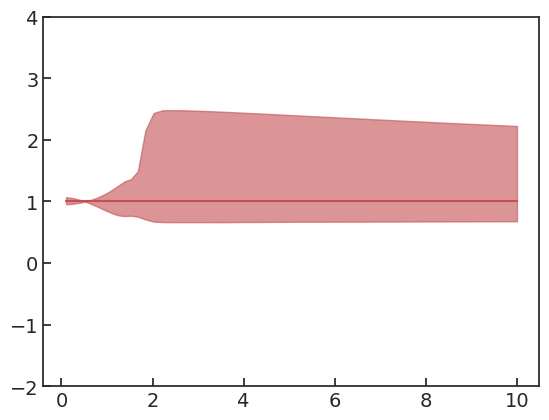

In [31]:
sp_norm = sp_comp[0]/sp_comp[0]
sp_norm_usd = sp_comp_usd/sp_comp[0]
sp_norm_dsd = sp_comp_dsd/sp_comp[0]
plt.plot(k, sp_norm, color = "r")
plt.fill_between(k, sp_norm_usd, sp_norm_dsd, alpha = 0.6, color = "r")
plt.ylim(-2.0, 4.0)